In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier, XGBRegressor
from sklift.datasets import fetch_lenta

from numpy.random import default_rng
rng = default_rng()

In [6]:
data = fetch_lenta()

In [52]:
T = data['treatment_name']
Y = data['target_name']
X = data['feature_names']
print(f'Treatment: {T}, Target: {Y}')
print(f'Features: {X}')

Treatment: group, Target: response_att
Features: ['age', 'cheque_count_12m_g20', 'cheque_count_12m_g21', 'cheque_count_12m_g25', 'cheque_count_12m_g32', 'cheque_count_12m_g33', 'cheque_count_12m_g38', 'cheque_count_12m_g39', 'cheque_count_12m_g41', 'cheque_count_12m_g42', 'cheque_count_12m_g45', 'cheque_count_12m_g46', 'cheque_count_12m_g48', 'cheque_count_12m_g52', 'cheque_count_12m_g56', 'cheque_count_12m_g57', 'cheque_count_12m_g58', 'cheque_count_12m_g79', 'cheque_count_3m_g20', 'cheque_count_3m_g21', 'cheque_count_3m_g25', 'cheque_count_3m_g42', 'cheque_count_3m_g45', 'cheque_count_3m_g52', 'cheque_count_3m_g56', 'cheque_count_3m_g57', 'cheque_count_3m_g79', 'cheque_count_6m_g20', 'cheque_count_6m_g21', 'cheque_count_6m_g25', 'cheque_count_6m_g32', 'cheque_count_6m_g33', 'cheque_count_6m_g38', 'cheque_count_6m_g39', 'cheque_count_6m_g40', 'cheque_count_6m_g41', 'cheque_count_6m_g42', 'cheque_count_6m_g45', 'cheque_count_6m_g46', 'cheque_count_6m_g48', 'cheque_count_6m_g52', 'chequ

In [57]:
df = pd.concat([data['target'], data['treatment'], data['data']], axis=1)
gender_map = {'Ж': 0, 'М': 1}
group_map = {'test': 1, 'control': 0}
df['gender'] = df['gender'].map(gender_map)
df['treatment'] = df['group'].map(group_map)
T = 'treatment'
df

,response_att,group,age,cheque_count_12m_g20,cheque_count_12m_g21,cheque_count_12m_g25,cheque_count_12m_g32,cheque_count_12m_g33,cheque_count_12m_g38,cheque_count_12m_g39,...,sale_sum_6m_g25,sale_sum_6m_g26,sale_sum_6m_g32,sale_sum_6m_g33,sale_sum_6m_g44,sale_sum_6m_g54,stdev_days_between_visits_15d,stdev_discount_depth_15d,stdev_discount_depth_1m,treatment
0,0,test,47.0,3.0,22.0,19.0,3.0,28.0,8.0,7.0,...,356.67,237.25,283.84,3648.23,1195.37,535.42,1.7078,0.2798,0.3008,1
1,0,test,57.0,1.0,0.0,2.0,1.0,1.0,1.0,0.0,...,62.69,58.71,87.01,179.83,0.00,122.98,0.0000,0.0000,0.0000,1
2,0,control,38.0,7.0,0.0,15.0,4.0,9.0,5.0,9.0,...,533.46,83.37,593.13,1217.43,1336.83,3709.82,0.0000,NaN,0.0803,0
3,0,test,65.0,6.0,3.0,25.0,2.0,10.0,14.0,11.0,...,1849.91,360.40,175.73,496.73,172.58,1246.21,0.0000,0.0000,0.0000,1
4,0,test,61.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,...,168.05,461.37,0.00,237.93,225.51,995.27,1.4142,0.3495,0.3495,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687024,0,control,35.0,0.0,0.0,4.0,0.0,2.0,0.0,1.0,...,669.33,111.87,0.00,330.96,1173.84,119.99,2.6458,0.3646,0.3282,0
687025,0,test,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,28.01,0.0000,0.0000,0.0000,1
687026,0,control,36.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,449.01,0.00,0.0000,NaN,NaN,0
687027,0,control,37.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,...,46.72,0.00,0.00,0.00,0.00,0.00,0.0000,NaN,NaN,0


In [58]:
smf.ols('response_att ~ treatment', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1026,0.001,136.592,0.000,0.101,0.104
treatment,0.0075,0.001,8.708,0.000,0.006,0.009


In [59]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=0)

# Fitting Metalearner Uplify Models

## S-Learner (single model)

In [66]:
slearner = XGBClassifier()
slearner.fit(df_train[X+[T]], df_train[Y])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [69]:
# Calculate the difference in predictions when T=1 vs T=0
slearner_te = slearner.predict_proba(df_test[X].assign(**{T: 1}))[:, 1] \
            - slearner.predict_proba(df_test[X].assign(**{T: 0}))[:, 1]

The mean treatment effect is 0.004.


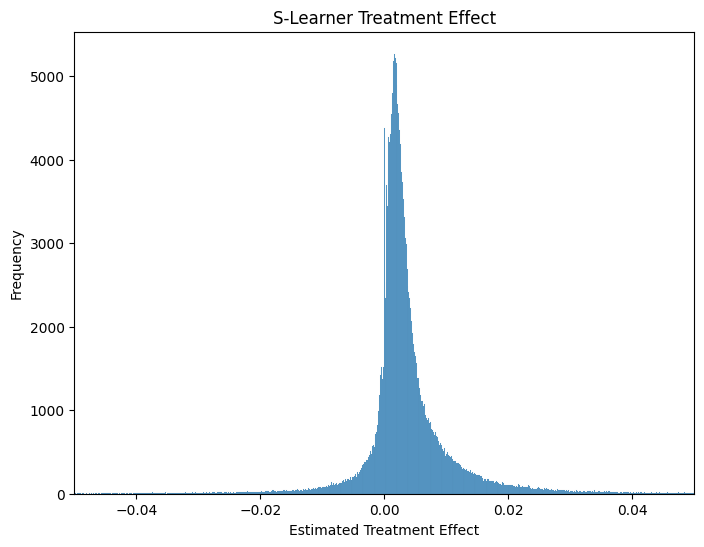

In [73]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(slearner_te, ax=ax)
ax.set_title('S-Learner Treatment Effect')
ax.set_xlabel('Estimated Treatment Effect')
ax.set_ylabel('Frequency')
ax.set_xlim(-0.05, 0.05);
print(f'The mean treatment effect is {slearner_te.mean():.3f}.')

## T-Learner (two models)

In [74]:
tlearner_0 = XGBClassifier()
tlearner_1 = XGBClassifier()

# Split data into treated and untreated
df_train_0 = df_train[df_train[T] == 0]
df_train_1 = df_train[df_train[T] == 1]

# Fit the models on each sample
tlearner_0.fit(df_train_0[X], df_train_0[Y])
tlearner_1.fit(df_train_1[X], df_train_1[Y])

# Calculate the difference in predictions
tlearner_te = tlearner_1.predict_proba(df_test[X])[:, 1] \
            - tlearner_0.predict_proba(df_test[X])[:, 1]

The mean treatment effect is 0.007.


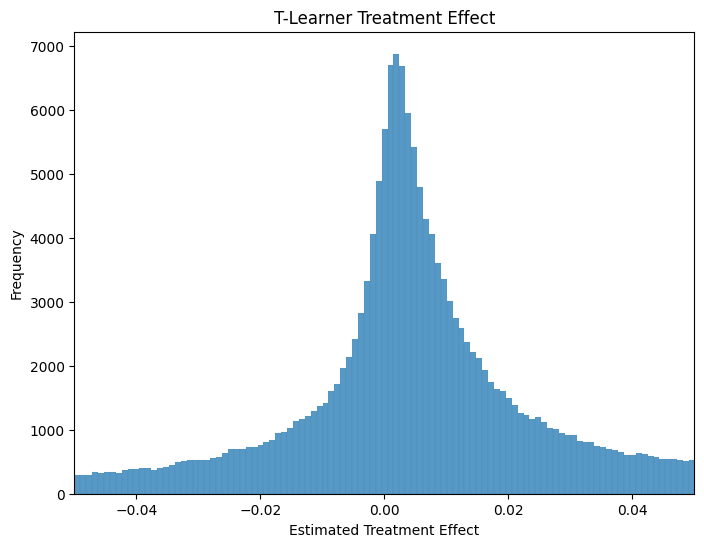

In [76]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(tlearner_te, ax=ax)
ax.set_title('T-Learner Treatment Effect')
ax.set_xlabel('Estimated Treatment Effect')
ax.set_ylabel('Frequency')
ax.set_xlim(-0.05, 0.05);
print(f'The mean treatment effect is {tlearner_te.mean():.3f}.')

## X-Learner Simple version (2 + 1 models)

In [83]:
xlearner_0 = XGBClassifier()
xlearner_1 = XGBClassifier()

xlearner_combined = XGBRegressor() # Even though the outcome is binary, the treatment effects are continuous

# Split data into treated and untreated
df_train_0 = df_train[df_train[T] == 0]
df_train_1 = df_train[df_train[T] == 1]

# Fit the models on each sample
xlearner_0.fit(df_train_0[X], df_train_0[Y])
xlearner_1.fit(df_train_1[X], df_train_1[Y])

# Calculate the difference between actual outcomes and predictions
xlearner_te_0 = xlearner_1.predict_proba(df_train_0[X])[:, 1] - df_train_0[Y]
xlearner_te_1 = df_train_1[Y] - xlearner_0.predict_proba(df_train_1[X])[:, 1]


The mean treatment effect is 0.007.


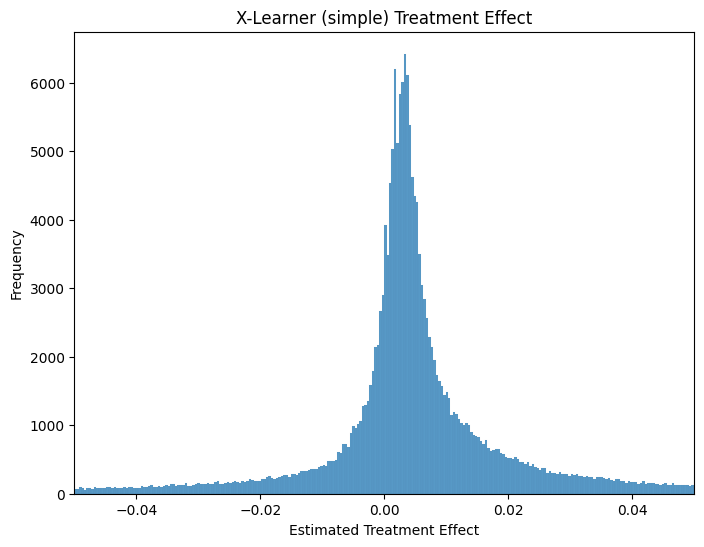

In [84]:
# Fit the combined model
xlearner_combined.fit(pd.concat([df_train_0, df_train_1])[X], pd.concat([xlearner_te_0, xlearner_te_1]))

# Predict treatment effects for each user
xlearner_simple_te = xlearner_combined.predict(df_test[X])

fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(xlearner_simple_te, ax=ax)
ax.set_title('X-Learner (simple) Treatment Effect')
ax.set_xlabel('Estimated Treatment Effect')
ax.set_ylabel('Frequency')
ax.set_xlim(-0.05, 0.05);
print(f'The mean treatment effect is {xlearner_simple_te.mean():.3f}.')

## X-Learner (2 + 2 + 1 models)

In [ ]:
# # The first few steps are exactly the same as the simple X-Learner
# # So if those have already been run, we can skip them

# xlearner_0 = XGBClassifier()
# xlearner_1 = XGBClassifier()

# xlearner_te_0 = XGBClassifier()
# xlearner_te_1 = XGBClassifier()

# xlearner_propensity = XGBClassifier()

# # Split data into treated and untreated
# df_train_0 = df_train[df_train[T] == 0]
# df_train_1 = df_train[df_train[T] == 1]

# # Fit the models on each sample
# xlearner_0.fit(df_train_0[X], df_train_0[Y])
# xlearner_1.fit(df_train_1[X], df_train_1[Y])

# # Calculate the difference between actual outcomes and predictions
# xlearner_te_0 = xlearner_1.predict_proba(df_train_0[X])[:, 1] - df_train_0[Y]
# xlearner_te_1 = xlearner_0.predict_proba(df_train_1[X])[:, 1] - df_train_1[Y]

In [87]:
# Define the new models that are not used in the simple version
xlearner_te_model_0 = XGBRegressor()
xlearner_te_model_1 = XGBRegressor()
xlearner_propensity = XGBClassifier()

xlearner_te_model_0.fit(df_train_0[X], xlearner_te_0)
xlearner_te_model_1.fit(df_train_1[X], xlearner_te_1)

# Calculate predictions from both models
xlearner_te_model_0_te = xlearner_te_model_0.predict(df_test[X])
xlearner_te_model_1_te = xlearner_te_model_1.predict(df_test[X])

# Calculate the propensity scores
xlearner_propensity.fit(df_train[X], df_train[T])
xlearner_propensities = xlearner_propensity.predict_proba(df_test[X])[:, 1]

# Calculate the treatment effects as propensity weighted average
xlearner_te = xlearner_propensities * xlearner_te_model_0_te + (1 - xlearner_propensities) * xlearner_te_model_1_te

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

The mean treatment effect is 0.006.


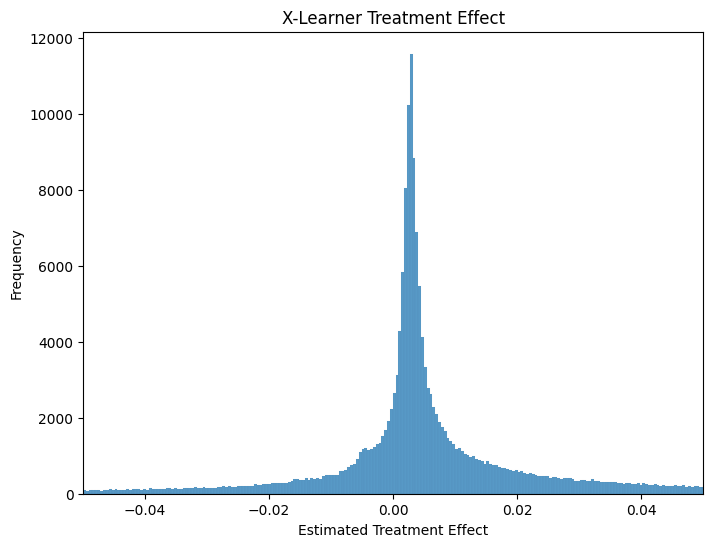

In [89]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(xlearner_te, ax=ax)
ax.set_title('X-Learner Treatment Effect')
ax.set_xlabel('Estimated Treatment Effect')
ax.set_ylabel('Frequency')
ax.set_xlim(-0.05, 0.05);
print(f'The mean treatment effect is {xlearner_te.mean():.3f}.')

# Evaluating and Comparing Models

In [93]:
from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
from sklift.viz import plot_qini_curve, plot_uplift_preds, plot_uplift_by_percentile, plot_uplift_curve

In [99]:
# ## Using Sklearn to fit the models
# When I tried it I got identical predictions to our manual ones

# from sklift.models import SoloModel, TwoModels
# slearner = SoloModel(XGBClassifier())
# slearner.fit(X=df_train[X], y=df_train[Y], treatment=df_train[T])
# slearner_sklift_te = slearner.predict(df_test[X])
# tlearner = TwoModels(XGBClassifier(), XGBClassifier())
# tlearner.fit(X=df_train[X], y=df_train[Y], treatment=df_train[T])
# tlearner_sklift_te = tlearner.predict(df_test[X])

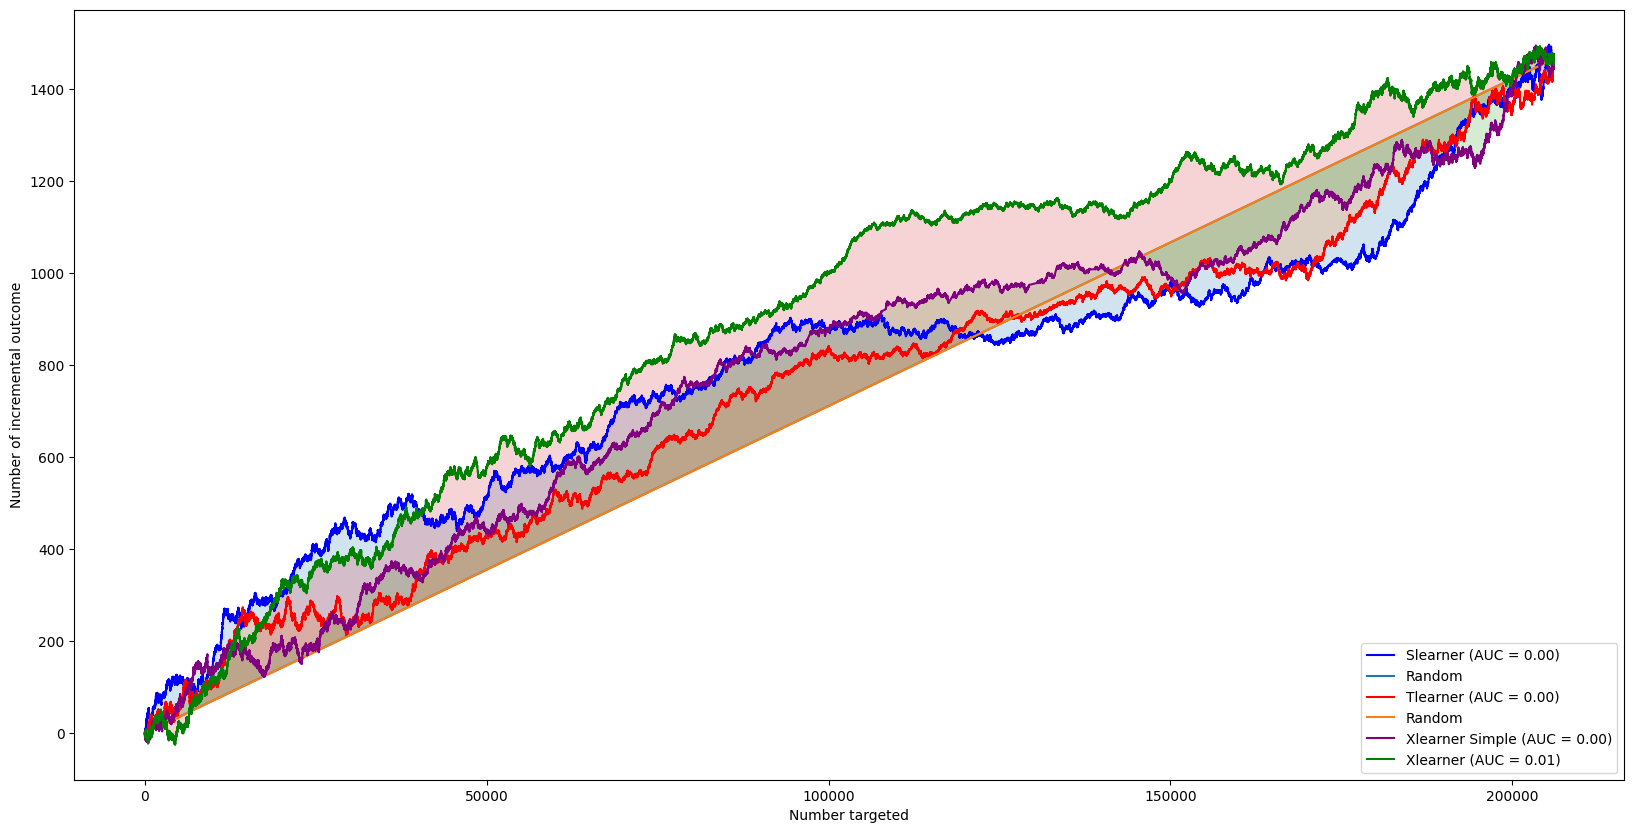

In [106]:
fig, ax = plt.subplots(figsize=(20, 10))
def plot_qini_short(model, label, color, linestyle):
    plot_qini_curve(df_test[Y], model, df_test[T], name=label, ax=ax, perfect=False, color=color, linestyle=linestyle)
plot_qini_short(slearner_te, 'Slearner', 'blue', 'solid')
plot_qini_short(tlearner_te, 'Tlearner', 'red', 'solid')
plot_qini_short(xlearner_simple_te, 'Xlearner Simple', 'purple', 'solid')
plot_qini_short(xlearner_te, 'Xlearner', 'green', 'solid')
ax.legend(loc='lower right');